In [27]:
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import matplotlib.pyplot as plt

In [28]:
def get_pauli_matrices():
    I = sparse.eye(2)
    X = sparse.csr_matrix([[0, 1], [1, 0]])
    Z = sparse.csr_matrix([[1, 0], [0, -1]])
    return I, X, Z

In [29]:
def get_translation_permutation(L):
    """
    Generates the permutation indices for a 1-site translation.
    T |b_L ... b_1> = |b_1 b_L ... b_2>
    """
    # Create all basis states as integers 0 to 2^L - 1
    basis = np.arange(2**L)
    
    # Bitwise roll: (x >> 1) | ((x & 1) << (L - 1))
    # This moves the lowest bit (site 0) to the highest bit (site L-1)
    # and shifts everything else down.
    permuted_basis = (basis >> 1) | ((basis & 1) << (L - 1))
    
    return permuted_basis

In [30]:
def build_hamiltonian_sparse(L, gx, gz):
    """Constructs TFIM Hamiltonian."""
    I, X, Z = get_pauli_matrices()
    dim = 2**L
    H = sparse.csr_matrix((dim, dim), dtype=np.float64)
    
    # Interaction: - sum Z_i Z_{i+1}
    for i in range(L):
        ops = [I] * L
        ops[i] = Z
        ops[(i + 1) % L] = Z
        term = ops[0]
        for op in ops[1:]:
            term = sparse.kron(term, op, format='csr')
        H -= term

    # Transverse: - gx sum X_i
    for i in range(L):
        ops = [I] * L
        ops[i] = X
        term = ops[0]
        for op in ops[1:]:
            term = sparse.kron(term, op, format='csr')
        H -= gx * term
        
    # Longitudinal: - gz sum Z_i
    if gz != 0:
        for i in range(L):
            ops = [I] * L
            ops[i] = Z
            term = ops[0]
            for op in ops[1:]:
                term = sparse.kron(term, op, format='csr')
            H -= gz * term
            
    return H

In [31]:
def check_momentum_zero(eigvec, perm_indices):
    """
    Checks if a state has Momentum k=0.
    A state has k=0 if it is invariant under translation T: T|psi> = +1|psi>
    """
    # Apply translation T by indexing
    translated_vec = eigvec[perm_indices]
    
    # Calculate overlap <psi | T | psi>
    overlap = np.vdot(eigvec, translated_vec)
    
    # If overlap is close to 1.0, it is k=0. 
    # If overlap is complex or < 1, it has momentum.
    return np.isclose(np.real(overlap), 1.0, atol=0.01)

In [32]:
def calculate_filtered_spectrum():
    L = 12                  # Increased to 12 for better resolution
    gx = 1.0                # Critical
    
    # Focus on the "Sweet Spot" for E8 (usually small gz)
    gz_values = np.logspace(-3, -0.1, 45)
    
    mass_ratios = []
    perm_indices = get_translation_permutation(L)
    
    print(f"Simulating L={L} with Momentum Filtering...")
    
    for gz in gz_values:
        H = build_hamiltonian_sparse(L, gx, gz)
        
        # Get MORE eigenvalues than needed (k=14), because we will throw away 
        # the momentum states (which might be lower energy than m2)
        evals, evecs = linalg.eigsh(H, k=50, which='SA')
        
        # Sort
        idx = evals.argsort()
        evals = evals[idx]
        evecs = evecs[:, idx]
        
        # --- FILTERING STEP ---
        k0_energies = []
        for i in range(len(evals)):
            if check_momentum_zero(evecs[:, i], perm_indices):
                k0_energies.append(evals[i])
                
        k0_energies = np.array(k0_energies)
        
        # Calculate Masses
        E0 = k0_energies[0]
        masses = k0_energies[1:] - E0
        
        # Normalize by m1
        m1 = masses[0]
        ratios = masses / m1
        
        # Pad with NaNs if we didn't find enough states
        if len(ratios) < 5:
            padded = np.full(5, np.nan)
            padded[:len(ratios)] = ratios
            mass_ratios.append(padded)
        else:
            mass_ratios.append(ratios[:5])

    mass_ratios = np.array(mass_ratios)

    # --- Plotting ---
    plt.figure(figsize=(10, 6))
    
    plt.axhline(y=1.618, color='k', linestyle='--', label=r'Golden Ratio $\phi$')
    
    plt.plot(gz_values, mass_ratios[:, 0], '.-', label=r'$m_1/m_1$')
    plt.plot(gz_values, mass_ratios[:, 1], 'o-', linewidth=2, label=r'$m_2/m_1$')
    
    plt.title(f'E8 Spectrum: Momentum $k=0$ Sector ($L={L}$)')
    plt.xlabel(r'Longitudinal Field $g_z$')
    plt.ylabel(r'Mass Ratio $m_i / m_1$')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0.8, 3.5) # Zoom in on the relevant area
    plt.show()

Simulating L=12 with Momentum Filtering...


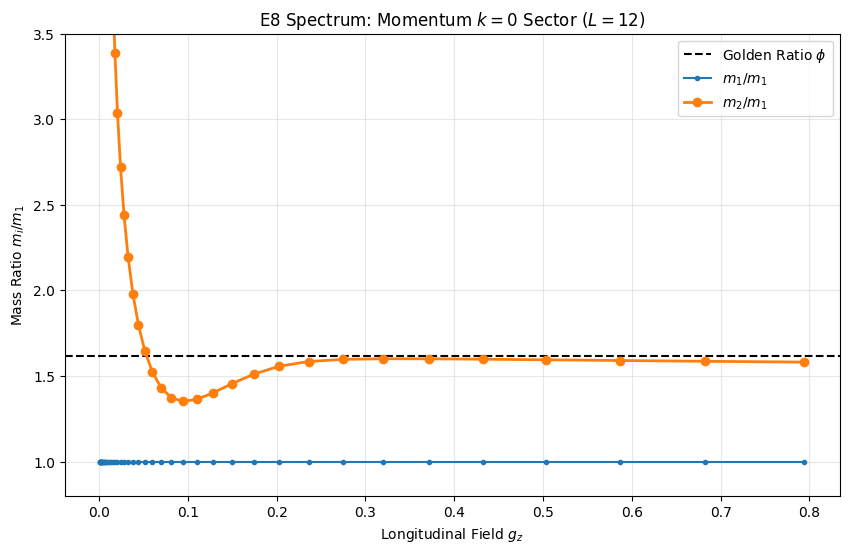

In [33]:
calculate_filtered_spectrum()